# Import data

In [10]:
! pip install --user 'pytz>=2017.2' 'fileupload>=0.1.2' 'ipywidgets>=6.0.0' 'pandas>=0.20.1' 'numpy>=1.12.1' 'matplotlib>=2.0.1' 'seaborn>=0.8'

In [2]:
from IPython.display import display, Markdown, FileLink, FileLinks, clear_output
import io, pytz, os, time, datetime, fileupload
import ipywidgets as widgets
import pandas as pd
import numpy as np

def _upload():
    
    _upload_widget = fileupload.FileUploadWidget()
    _tz_widget = widgets.Dropdown(options=pytz.common_timezones, value='UTC', description='Timezone: ')
    _mm_widget = widgets.Checkbox(description='Remove MICS metadata', value=True)

    def _cb(change):
        
        if len(readings) == 2:
            print 'For now we can only process two files at he same time'
            return
        
        # get file
        decoded = io.StringIO(change['owner'].data.decode('utf-8'))
        filename = change['owner'].filename 
        fileData = io.StringIO(change['new'].decode('utf-8'))
        df = pd.read_csv(fileData).set_index('Time')
        
        # prepare dataframe
        df.index = pd.to_datetime(df.index).tz_localize('UTC').tz_convert(_tz_widget.value)
        df.sort_index(inplace=True)
        df = df.groupby(pd.TimeGrouper(freq='2Min')).aggregate(np.mean)
        if _mm_widget.value:
            df.drop([i for i in df.columns if 'heat' in i or 'load' in i or 'Unnamed' in i], axis=1, inplace=True)
        df.columns = [c.split('-', 1)[0] for c in df.columns]
        readings[filename] = df[df.index > '2001-01-01T00:00:01Z']
        listFiles(filename)
    
    # widgets
    _upload_widget.observe(_cb, names='data')
    _hb = widgets.HBox([_upload_widget, _tz_widget, widgets.HTML(' '),_mm_widget])
    
    display(_hb)

def delFile(b):
    clear_output()
    for d in list(b.hbl.children): d.close()
    readings.pop(b.f)

def describeFile(b):
    clear_output()
    display(readings[b.f].describe())
    
def exportFile(b):
    export_dir = os.path.join('data', 'exports')
    if not os.path.exists(export_dir): os.mkdir(export_dir)
    savePath = os.path.join(export_dir, b.f+'_clean_'+datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%dT%H:%M:%S')
+'.csv')
    if not os.path.exists(savePath):
        readings[b.f].to_csv(savePath, sep=",")
        display(FileLink(savePath))
    else:
        display(widgets.HTML(' File Already exists!'))
    
def listFiles(filename):
    clear_output()
    temp = list(fileList.children)
    cb = widgets.Button(icon='close',layout=widgets.Layout(width='30px'))
    cb.on_click(delFile)
    cb.f = filename
    eb = widgets.Button(description='Export processed CSV', layout=widgets.Layout(width='180px'))
    eb.on_click(exportFile)
    eb.f = filename
    sb = widgets.Button(description='describe', layout=widgets.Layout(width='80px'))
    sb.on_click(describeFile)
    sb.f = filename
    hbl = widgets.HBox([cb, widgets.HTML(' <b>'+filename+'</b> \t'), sb, eb])
    cb.hbl = hbl
    eb.hbl = hbl
    temp.append(hbl)
    fileList.children = temp

readings = {}
display(widgets.HTML('<hr><h3>Select CSV files</h3>'))
_upload()
fileList = widgets.VBox([widgets.HTML('<hr>')])
display(fileList)



# Plot

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)

%matplotlib inline
matplotlib.style.use('seaborn-whitegrid')

# remap values to a 0-1 range
remap = False

toshow = []

def show_sensors(Source):
    _sensor_drop.options = [s for s in list(readings[Source].columns)]
    _sensor_drop.source = Source

def clear_all(b):
    clear_output()
    del toshow[:]
        
def add_sensor(b):
    clear_output()
    d = [_sensor_drop.source, _sensor_drop.value]
    if d not in toshow: toshow.append(d)
    
    plot_data = readings[toshow[0][0]].loc[:,(toshow[0][1],)]
        
    if len(toshow) > 1:
        for i in range(1, len(toshow)):
            plot_data = pd.merge(plot_data, readings[toshow[i][0]].loc[:,(toshow[i][1],)], left_index=True, right_index=True)
    
    if remap:
        plot_data = plot_data.sub(plot_data.min())
        plot_data = plot_data.div(plot_data.max())
        
    changed = []
    for i in range(len(plot_data.columns)):
        changed.append(toshow[i][0] + ' - '+ plot_data.columns[i])
    plot_data.columns = changed
    sns.set(font_scale=1.4)  
    ax = plot_data.plot(figsize=(14, 8), linewidth=2, alpha=0.75)
    ax.legend(bbox_to_anchor=(1, 1), loc=4)
    ax.grid(which='both')                                                                                           
    ax.grid(which='minor', alpha=1)                                                
    ax.grid(which='major')
    
    if remap: plt.ylim(0, 1.05)
    

layout=widgets.Layout(width='350px')
_kit = widgets.Dropdown(options=[k for k in readings.keys()], layout=layout)
_kit_drop = widgets.interactive(show_sensors, Source=_kit, layout=layout)
_sensor_drop = widgets.Dropdown(layout=layout)
_b_add = widgets.Button(description='Add', layout=widgets.Layout(width='100px'))
_b_add.on_click(add_sensor)
_b_reset = widgets.Button(description='Clear all', layout=widgets.Layout(width='100px'))
_b_reset.on_click(clear_all)
_sensor_box = widgets.HBox([_sensor_drop, _b_add, _b_reset])
root_box = widgets.VBox([_kit_drop, _sensor_box])
display(root_box)

# Correlation Matrix

In [7]:
def paint(Source):
    clear_output()
    fig, ax = plt.subplots(figsize=(9, 6))
    sns.set(font_scale=1.3)
    sns.heatmap(readings[Source].corr(), annot=True, fmt='.2f', linewidths=.5, ax=ax, cmap=sns.color_palette("Blues"))
    plt.show()

_kit = widgets.Dropdown(options=[k for k in readings.keys()], layout=layout)
_kit_drop = widgets.interactive(paint, Source=_kit, layout=layout)
display(_kit_drop)

# Correlation grid

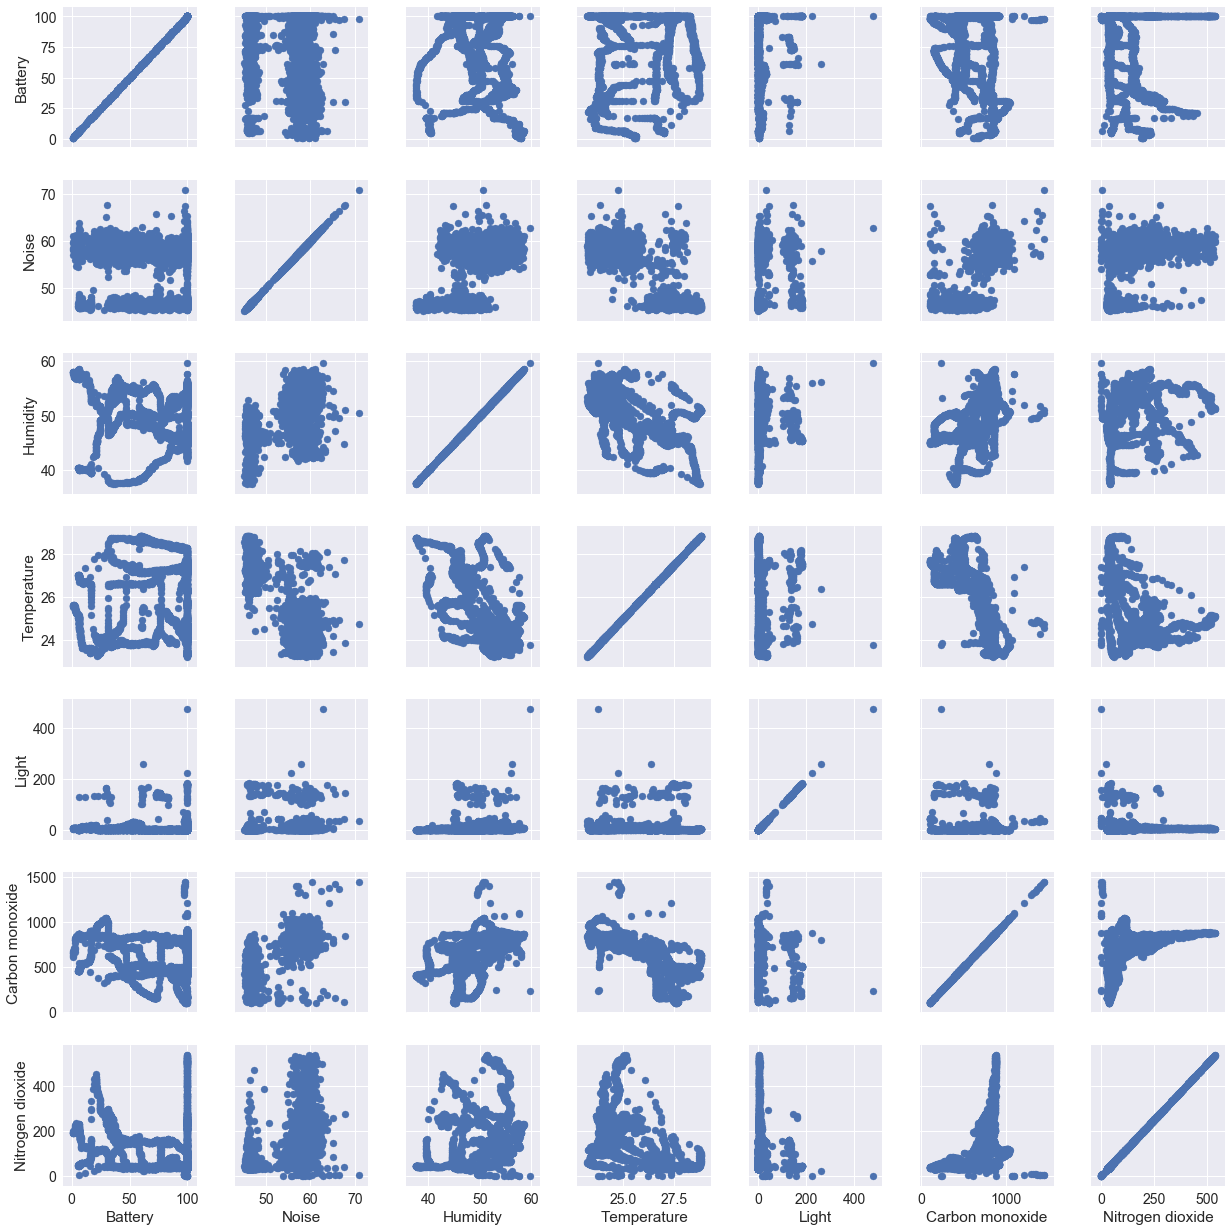

In [8]:
def paint(Source):
    clear_output()
    sns.set(font_scale=1.4)
    g = sns.PairGrid(readings.values()[0])
    g = g.map(plt.scatter)

_kit = widgets.Dropdown(options=[k for k in readings.keys()], layout=layout)
_kit_drop = widgets.interactive(paint, Source=_kit, layout=layout)
display(_kit_drop)

# Correlation

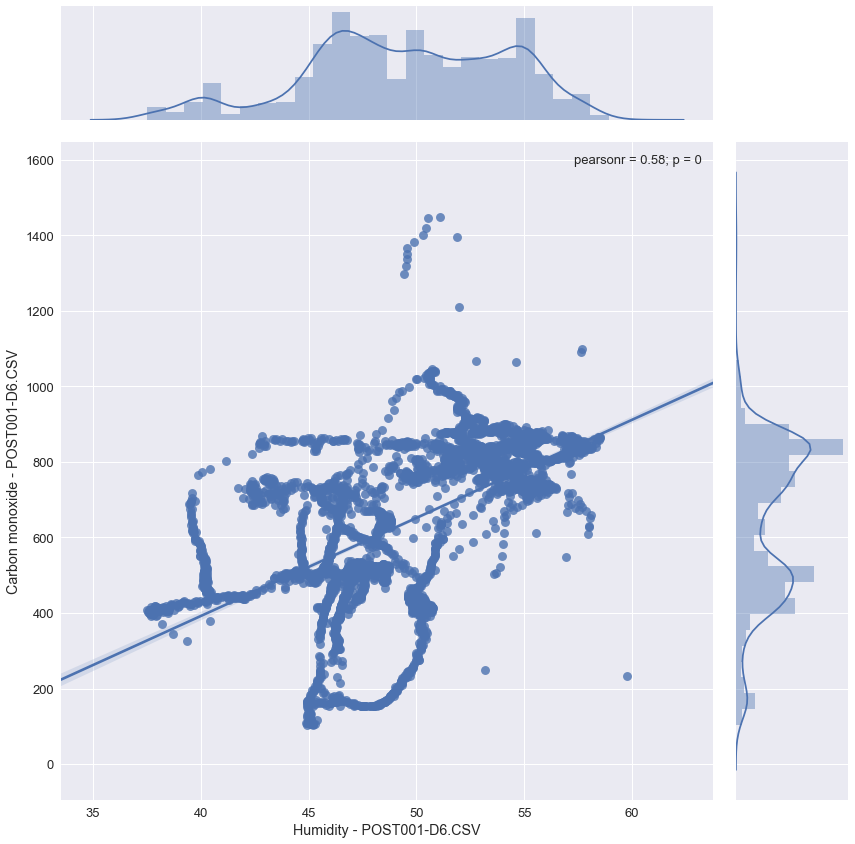

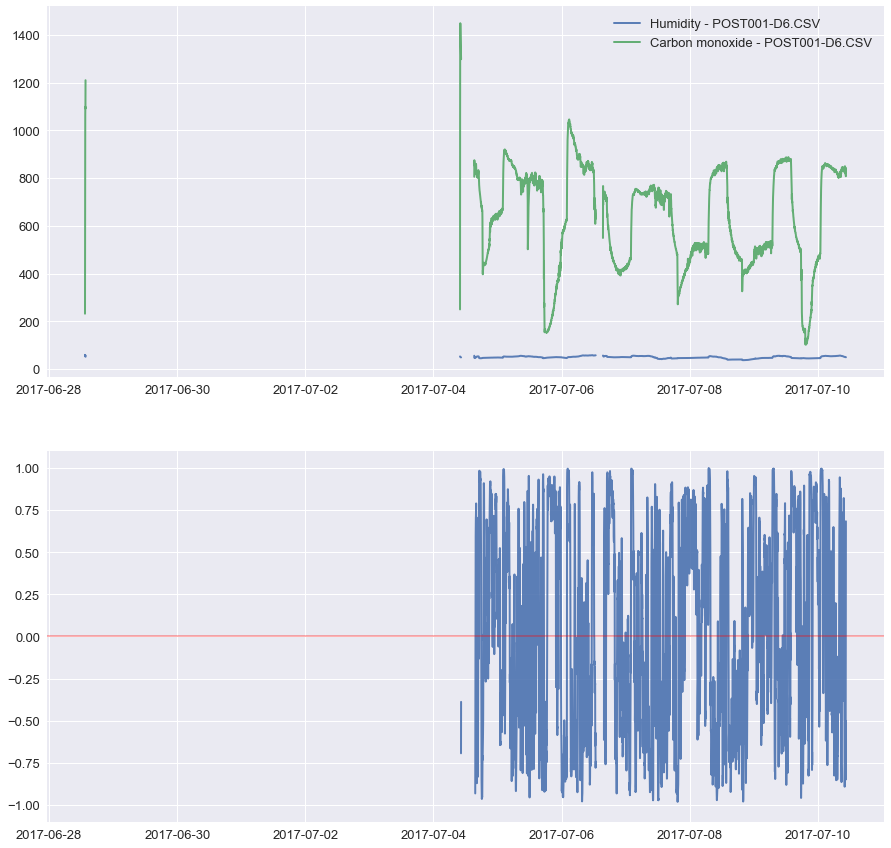

In [9]:
def redraw(b):
    mergedData = pd.merge(readings[A_kit.value].loc[:,(A_sensors.value,)], readings[B_kit.value].loc[:,(B_sensors.value,)], left_index=True, right_index=True, suffixes=('_'+A_kit.value, '_'+B_kit.value))
    clear_output()
    
    #jointplot
    df = pd.DataFrame()
    A = A_sensors.value + ' - ' + A_kit.value
    B = B_sensors.value + ' - ' + B_kit.value
    df[A] = mergedData.iloc[:,0]
    df[B] = mergedData.iloc[:,1]
    sns.set(font_scale=1.3)
    sns.jointplot(A, B, data=df, kind="reg", color="b", size=12, scatter_kws={"s": 80});

    # plot
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(2,1,1)
    ax.plot(df, linewidth=2, alpha=0.9)
    ax.legend(list(df.columns))

    # Rolling correlation
    roll = mergedData.iloc[:,0].rolling(12).corr(mergedData.iloc[:,1])
    ax1 = fig.add_subplot(2,1,2,sharex=ax)
    ax1.plot(roll, linewidth=2, alpha=0.9)
    plt.ylim([-1.1,1.1])
    ax1.axhline(0, color='red', alpha=0.35)
    
if len(readings) < 1: print "Please load some data first..."
else:
    layout=widgets.Layout(width='300px')
    b_redraw = widgets.Button(description='Redraw', layout=widgets.Layout(width='180px'))
    b_redraw.on_click(redraw)
    A_kit = widgets.Dropdown(options=[k for k in readings.keys()], layout=layout)
    A_sensors = widgets.Dropdown(options=[s for s in list(readings.values()[0].columns)], layout=layout)
    B_kit = widgets.Dropdown(options=[k for k in readings.keys()],  value=readings.keys()[0], layout=layout)
    B_sensors = widgets.Dropdown(options=[s for s in list(readings.values()[0].columns)], layout=layout)
    kit_box = widgets.HBox([A_kit, widgets.HTML('<h4><< Data source selection >></h4>') , B_kit], layout=widgets.Layout(justify_content='space-between'))
    sensor_box = widgets.HBox([A_sensors, widgets.HTML('<h4><< Sensor selection >></h4>') , B_sensors], layout=widgets.Layout(justify_content='space-between'))
    root_box = widgets.VBox([b_redraw, kit_box, sensor_box])
    display(root_box)
    redraw(b_redraw)